# [Face Recognition](#face-recognition)

In this notebook, we will develop a face recognition system, drawing on key concepts from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) and insights from [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

Face recognition problems typically fall into two main categories:

**Face Verification:** This task addresses the question, "Is this the claimed person?" For instance, at certain airports, individuals can pass through customs by allowing a system to scan their passport and confirm their identity as the rightful owner. Similarly, mobile phones that utilize facial recognition technology for unlocking are also examples of face verification, representing a 1:1 matching problem.

**Face Recognition:** This task seeks to answer the question, "Who is this person?" An example can be seen in a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) showcasing Baidu employees entering their office without the need for additional identification, illustrating a 1:K matching problem.

FaceNet employs a neural network that encodes a face image into a vector comprising 128 numbers. By comparing two such vectors, we can determine whether two images depict the same individual.

By the end of this notebook, we will achieve the following objectives:

* Differentiate between face recognition and face verification.
* Implement one-shot learning to address a face recognition challenge.
* Apply the triplet loss function to optimize a network's parameters in the context of face recognition.
* Explain how to formulate face recognition as a binary classification problem.
* Map face images into 128-dimensional encodings using a pretrained model.
* Perform both face verification and face recognition utilizing these encodings.

**Channels-Last Notation**

In this work, we will utilize a pre-trained model that represents ConvNet activations using a "channels last" convention, as discussed in previous lectures and programming assignments. Consequently, a batch of images will be structured in the shape \((m, n_H, n_W, n_C)\).


## Table of Contents

- [1 - Packages](#1-packages)
- [2 - Naive Face Verification](#2-naive-face-verification)
- [3 - Encoding Face Images into a 512-Dimensional Vector](#3-encoding-face-images-into-a-512-dimensional-vector)
    - [3.1 - Using a FaceNet (ConvNet) to Compute Encodings](#3-1-using-a-convnet-to-compute-encodings)
    - [3.2 - The Triplet Loss](#3-2-the-triplet-loss)
        - [Triplet Loss Function Implementation](#triplet-loss-function-implementation)
- [4 - Loading the Pre-trained Model](#4-loading-the-pre-trained-model)
- [5 - Applying the Model](#5-applying-the-model)
    - [5.1 - Face Verification](#5-1-face-verification)
        - [Verification Function Implementation](#verification-function-implementation)
    - [5.2 - Face Recognition](#5-2-face-recognition)
        - [Recognition Function Implementation](#recognition-function-implementation)
- [6 - Congratulations](#6-congratulations)
    - [6.1 - Key Accomplishments](#6-1-key-accomplishments)
    - [6.2 - Important Takeaways](#6-2-important-takeaways)
    - [6.3 - Future Enhancements for the Facial Recognition Model](#6-3-future-enhancements)
- [7 - References](#7-references)


<a name='1-packages'></a>
## 1 - Packages

In this section, we will import the essential packages required for the implementation of the face recognition system. 


In [33]:
from keras_facenet import FaceNet
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

<a name='2-naive-face-verification'></a>
## 2 - Naive Face Verification

In the context of face verification, the objective is to determine whether two given images depict the same individual. A straightforward approach to achieve this is by comparing the two images pixel-by-pixel. If the distance between the raw pixel values of the images falls below a predetermined threshold, one might conclude that the images represent the same person.

<img src="images/pixel_comparison.png" alt="Pixel Comparison" style="width:380px;height:150px;">  
<caption><center><u><font color='purple'><b>Figure 1</b></font></u></center></caption>


However, this algorithm is notably ineffective due to the significant variability in pixel values resulting from factors such as lighting conditions, the orientation of the person's face, and minor changes in head position.

Instead of relying on raw images, we can learn a more robust encoding function, denoted as \( f($\text{img}$) \).

By utilizing an encoding for each image, an element-wise comparison yields a more accurate determination of whether the two images correspond to the same individual.


<a name='3-encoding-face-images-into-a-512-dimensional-vector'></a>
## 3 - Encoding Face Images into a 512-Dimensional Vector

<a name='3-1-using-a-convnet-to-compute-encodings'></a>
### 3.1 - Using a FaceNet (ConvNet) to Compute Encodings

The FaceNet model is designed for face recognition and uses a pre-trained architecture based on Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842).  The FaceNet model is detailed in the paper "FaceNet: A Unified Embedding for Face Recognition and Clustering." For this implementation, we will utilize the `keras_facenet` package, which simplifies the process of loading the pre-trained model. The model can accept RGB images with dimensions of 160x160 pixels, and it outputs a matrix of shape \((m, 512)\), encoding each input face image into a 512-dimensional vector. This approach allows us to leverage existing research and obtain high-quality embeddings for our face recognition tasks.

In [2]:
# Initialize the FaceNet model
embedder = FaceNet()

# Access the underlying Keras model
model = embedder.model


2024-11-04 07:18:23.928896: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now summarize the input and output shapes: 

In [3]:
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>]
[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_449>]


The FaceNet model generates 512-dimensional embeddings, which serve as robust representations of face images. We can compare two face images using these encodings, as illustrated below:

<img src="images/distance_kiank.png" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 2:</b> <br> </u> <font color='purple'>By computing the distance between two encodings and applying a threshold, we can determine whether the two pictures represent the same person.</center></caption>

**Note:** The above image utilizes 128-dimensional embeddings for illustration, but it is important to remember that FaceNet generates 512-dimensional embeddings. For the purpose of understanding the underlying concept, the specific dimensionality of the embeddings does not significantly affect the overall approach.

An encoding is considered effective if:

- The encodings of two images of the same person are closely similar to each other.
- The encodings of two images of different individuals are distinctly different.

The triplet loss function formalizes this principle by striving to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while simultaneously "pulling" the encodings of two images of different persons (Anchor and Negative) further apart.

<img src="images/triplet_comparison.png" style="width:400px;height:250px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 3: </b> <br> </u> <font color='purple'>In the next section, you will refer to the pictures from left to right as Anchor (A), Positive (P), and Negative (N).</center></caption>

**Note:** Similar to the previous note, the illustration above employs 128-dimensional embeddings, but remember that FaceNet produces 512-dimensional embeddings. The core concept remains intact, regardless of the dimensionality of the embeddings used.

<a name='#3-2-the-triplet-loss'></a>
### 3.2 - The Triplet Loss

The triplet loss function is a crucial component of the face recognition algorithm, particularly when utilizing models such as FaceNet. Although we are employing a pretrained model and do not need to implement the triplet loss function directly in this context, understanding its mechanics is essential for training our own FaceNet models and for various image similarity tasks.

For an image $x$, its encoding is represented as $f(x)$, where $f$ is the function derived from the neural network.

<img src="images/f_x.png" alt="Encoding Function" style="width:380px;height:150px;">

**Note:** The above image utilizes 128-dimensional embeddings for illustration, but it is important to remember that FaceNet generates 512-dimensional embeddings. For the purpose of understanding the underlying concept, the specific dimensionality of the embeddings does not significantly affect the overall approach.


The training process utilizes triplets of images denoted as $(A, P, N)$:

- $A$ is the "Anchor" image, depicting a specific individual.
- $P$ is the "Positive" image, representing the same individual as the Anchor.
- $N$ is the "Negative" image, showcasing a different individual from the Anchor.

These triplets are selected from the training dataset, with $(A^{(i)}, P^{(i)}, N^{(i)})$ representing the $i$-th training example.

The objective is to ensure that the encoding of the image $A^{(i)}$ is closer to the encoding of the Positive image $P^{(i)}$ than to that of the Negative image $N^{(i)}$ by at least a margin $\alpha$:


The objective is to ensure that the encoding of the image $A^{(i)}$ is closer to the encoding of the Positive image $P^{(i)}$ than to that of the Negative image $N^{(i)}$ by at least a margin $\alpha$:

$$
|| f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2} + \alpha < || f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2}
$$

To achieve this, we aim to minimize the following triplet cost function:

$$
\mathcal{J} = \sum^{m}_{i=1} \left[ \underbrace{|| f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2}}_{\text{(1)}} - \underbrace{|| f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2}}_{\text{(2)}} + \alpha \right]_{+}
$$

Here, the notation $[z]_{+}$ indicates $\max(z,0)$.


**Key Points**:

- The term (1) represents the squared distance between the Anchor $A$ and the Positive $P$ for a given triplet, which we aim to minimize.
- The term (2) denotes the squared distance between the Anchor $A$ and the Negative $N$, which we desire to maximize. The negative sign preceding this term allows us to effectively minimize its negative, thereby maximizing the distance.
- The margin $\alpha$ is a hyperparameter, manually set at $\alpha = 0.2$.

In most implementations, encoding vectors are also rescaled to have an L2 norm of one (i.e., $|| f(img) ||_{2} = 1$), although this aspect is not a concern for our current focus.


<a name='triplet-loss-function-implementation'></a>
### Triplet Loss Implementation

To implement the triplet loss as defined by the formula above, we will perform the following steps:

1. Compute the distance between the encodings of the Anchor and Positive images: 
   $$|| f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2}.$$
   
2. Compute the distance between the encodings of the Anchor and Negative images: 
   $$|| f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2}.$$
   
3. Derive the formula for each training example: 
   $$
   || f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2} - || f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2} + \alpha.
   $$
   
4. Calculate the overall formula by taking the maximum with zero and summing over the training examples:
   $$
   \mathcal{J} = \sum^{m}_{i=1} \left[ || f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2} - || f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2} + \alpha \right]_{+}.
   $$


**Considerations**:

- Useful TensorFlow functions for implementation include `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, and `tf.maximum()`.

- In steps 1 and 2, it is essential to sum over the entries of 
  $$|| f(A^{(i)}) - f(P^{(i)}) ||_{2}^{2}$$ 
  and 
  $$|| f(A^{(i)}) - f(N^{(i)}) ||_{2}^{2}.$$ 

- In step 4, sum across the training examples to obtain a single scalar value.



In [5]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    """
    Triplet loss function as defined by formula (3).
    
    Arguments:
    y_true -- true labels (not used in this function).
    y_pred -- list containing three elements:
              anchor -- encodings for the anchor images, shape (None, 512)
              positive -- encodings for the positive images, shape (None, 512)
              negative -- encodings for the negative images, shape (None, 512)
    
    Returns:
    loss -- value of the triplet loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

<a name='4-loading-the-pre-trained-model'></a>
## 4 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. However, training from scratch necessitates substantial data and computational resources. In this section, we will load a previously trained model, which may take a couple of minutes to complete.


In [4]:
FRmodel = model

Here are some examples of distances between the encodings of three individuals:

<img src="images/distance_matrix.png" style="width:380px;height:200px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 4:</b></u> <br>  <font color='purple'> Example of distance outputs between the encodings of three individuals</center></caption>

**Note:** The image above illustrates distances calculated from 128-dimensional embeddings. However, it is important to note that our FaceNet generates 512-dimensional embeddings. For the purpose of understanding the underlying concept, the specific dimensionality of the embeddings does not significantly affect the overall approach. The key idea is that images of the same person exhibit smaller distances, while images of different individuals display larger distances.

We will now utilize this model to perform face verification and face recognition.


<a name='5-applying-the-model'></a>
## 5 - Applying the Model

In this section, we are developing a facial recognition system for an office building, as requested by the building manager. The goal is to facilitate access for employees through a face verification process.

To gain entry, each individual must first swipe an identification card at the entrance. The facial recognition system will then verify that the person is indeed who they claim to be.

<a name='5-1-face-verification'></a>
### 5.1 - Face Verification

We will create a database that contains a unique encoding vector for each authorized individual. This encoding will be generated using the function `img_to_encoding(image_path, model)`, which performs forward propagation through the model on the specified image.

The following code builds the database, which is represented as a Python dictionary. This database maps each individual’s name to the corresponding 512-dimensional encoding of their face.


In [6]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.array(img) / 255.0
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)


In [7]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the images of Danielle and Kian: 

In [8]:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))

displaying shape of `kian` image and actual image

In [9]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

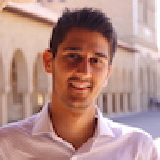

In [10]:
kian

displaying shape of `danielle` image and actual image

In [11]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

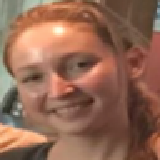

In [12]:
danielle

Now, when an individual arrives at the front door and swipes their ID card, thereby providing their name, we can look up their corresponding encoding in the database. This allows us to verify whether the individual standing at the entrance matches the name on the ID.

<a name='verification-function-implementation'></a>
### Verification Function

To implement the `verify()` function, we will check if the image captured by the front-door camera (`image_path`) corresponds to the individual identified as "identity." The process involves the following steps:

1. **Compute the Encoding**: Calculate the encoding of the image using the `img_to_encoding` function, which takes `image_path` and the trained model as inputs.

2. **Calculate the Distance**: Measure the distance between the computed encoding and the encoding of the identity image stored in the database.

3. **Access Decision**: Grant access if the computed distance is less than 0.7; otherwise, deny access.

The L2 distance will be utilized for this calculation, specifically using the function `np.linalg.norm`.

**Note**: It is important to compare the L2 distance directly, rather than the square of the L2 distance, against the threshold of 0.7.

*Hints*:

- The variable `identity` is a string that serves as a key in the database dictionary.
- The `img_to_encoding` function requires two parameters: the `image_path` and the model.


In [34]:
def verify(image_path, identity, database, model):
    """
    Verifies if the person in the image at "image_path" matches the identity in the database.
    
    Arguments:
        image_path -- path to an image
        identity -- name of the person to verify
        database -- dictionary mapping names to their encodings
        model -- FaceNet model instance
    
    Returns:
        dist -- distance between the encoding of "image_path" and the database encoding
        door_open -- True if identity matches, False otherwise
    """
    # Compute the encoding for the image
    encoding = img_to_encoding(image_path, model)
    
    # Compute the distance to the database encoding for the given identity
    dist = np.linalg.norm(database[identity] - encoding)
    
    # Determine if the distance is within the threshold
    door_open = dist < 0.7

    # Display the images side by side
    identity_image_path = f'images/{identity}.jpg'  # Assuming identity images are stored in 'images/' directory
    identity_image = Image.open(identity_image_path)
    new_person_image = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    # Display identity image
    plt.subplot(1, 2, 1)
    plt.imshow(identity_image)
    plt.title(f'Image of {identity}')
    plt.axis('off')

    # Display new person image
    plt.subplot(1, 2, 2)
    plt.imshow(new_person_image)
    plt.title('New Person Image')
    plt.axis('off')

    plt.show()

    if door_open:
        print(f"It's {identity}, welcome in!")
    else:
        print(f"It's not {identity}, please go away")
        
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run our verification algorithm on this picture:

<img src="images/camera_0.jpg" style="width:100px;height:100px;">

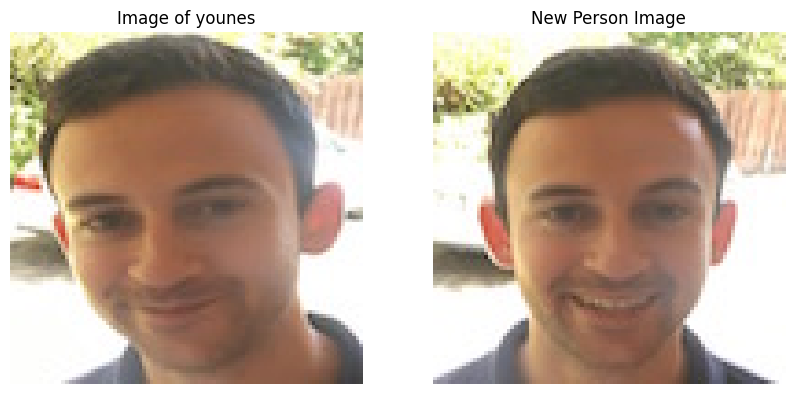

It's younes, welcome in!


(np.float32(0.5448771), np.True_)

In [35]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg). 

<img src="images/camera_2.jpg" style="width:100px;height:100px;">

Run the verification algorithm to check if Benoit can enter.

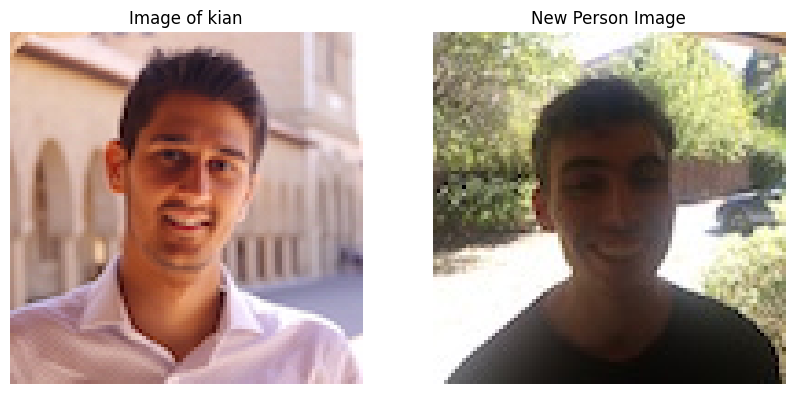

It's not kian, please go away


(np.float32(1.3556261), np.False_)

In [36]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

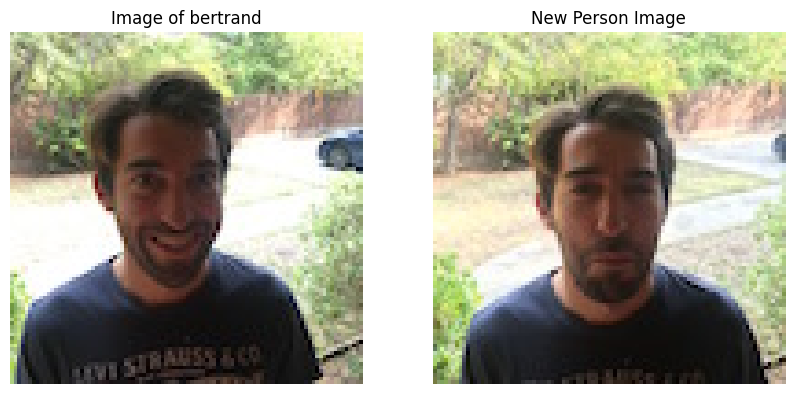

It's not bertrand, please go away


(np.float32(0.85924834), np.False_)

In [37]:
verify("images/camera_1.jpg", "bertrand", database, FRmodel)

It seems that the "images/camera_1.jpg" of bertrand is too distorted, so the algorithm could not recognize him

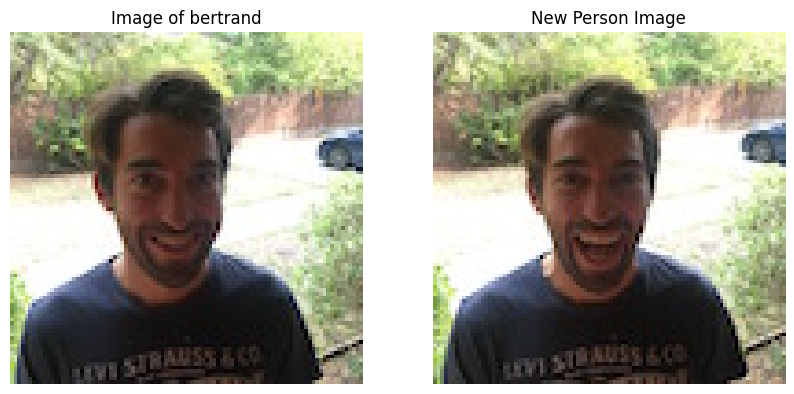

It's bertrand, welcome in!


(np.float32(0.66918975), np.True_)

In [38]:
verify("images/camera_3.jpg", "bertrand", database, FRmodel)

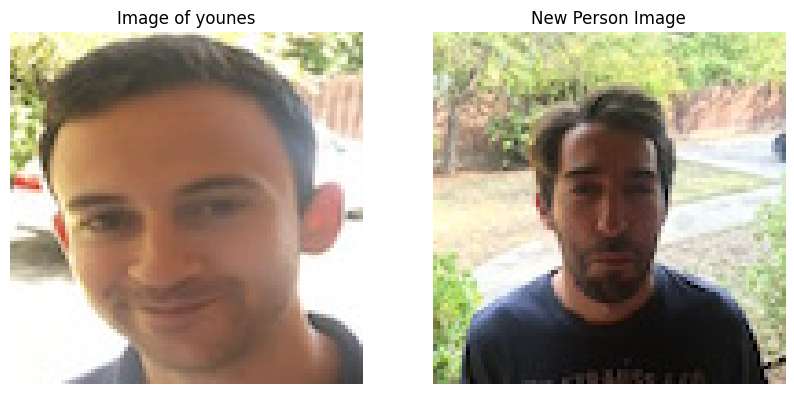

It's not younes, please go away


(np.float32(1.5618715), np.False_)

In [39]:
verify("images/camera_1.jpg", "younes", database, FRmodel)

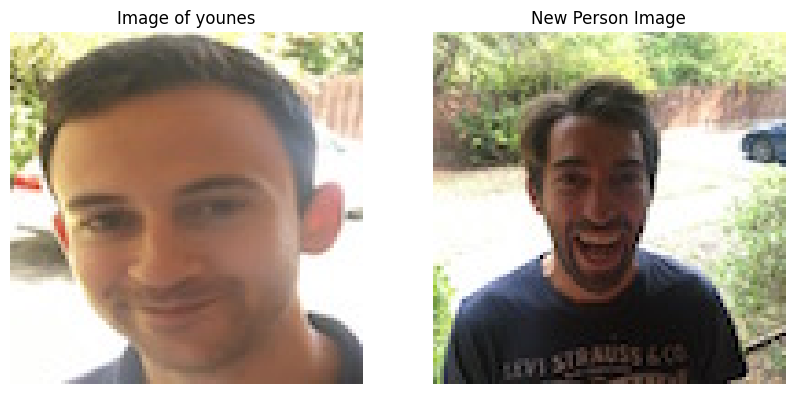

It's not younes, please go away


(np.float32(1.5632664), np.False_)

In [40]:
verify("images/camera_3.jpg", "younes", database, FRmodel)

<a name='5-2-face-recognition'></a>
### 5.2 - Face Recognition

The face verification system is functioning effectively; however, a recent incident involving Kian, who lost his ID card, highlighted a limitation in the current approach. When Kian returned to the office the following day, he was unable to gain entry.

To address this issue, we aim to transition from a face verification system to a face recognition system. This change will eliminate the necessity for individuals to carry ID cards. Instead, authorized personnel will be able to approach the building, and the door will unlock automatically for them.

In this phase, we will implement a face recognition system that accepts an image as input and determines whether it corresponds to one of the authorized individuals, without requiring the person's name as input.

<a name='recognition-function-implementation'></a>
### Who Is It

We will develop the `who_is_it()` function, following these steps:

1. **Compute the Target Encoding**: Calculate the encoding of the image specified by `image_path`.
2. **Identify Closest Encoding**: Determine the encoding in the database that has the smallest distance to the computed target encoding.
3. **Initialize Minimum Distance**: Set the `min_dist` variable to a sufficiently large value (e.g., 100) to keep track of the closest encoding to the input's encoding.
4. **Iterate Through Database**: Loop over the names and encodings in the database using the format `for (name, db_enc) in database.items()`.
5. **Calculate L2 Distance**: For each encoding in the database, compute the L2 distance between the target encoding and the current database encoding. If this distance is less than `min_dist`, update `min_dist` and assign the corresponding name to the variable `identity`.


In [42]:
def who_is_it(image_path, database, model):
    """
    Identifies the person in the image at "image_path" by finding the closest match in the database.
    
    Arguments:
        image_path -- path to an image
        database -- dictionary with names as keys and encodings as values
        model -- FaceNet model instance
    
    Returns:
        min_dist -- minimum distance between "image_path" encoding and database encodings
        identity -- predicted name of the person in the image, or "Unknown" if no match
    """
    # Compute encoding for the image
    encoding = img_to_encoding(image_path, model)
    
    # Initialize minimum distance and identity
    min_dist = 100
    identity = "Unknown"
    
    # Find the closest match in the database
    for name, db_enc in database.items():
        dist = np.linalg.norm(db_enc - encoding)
        if dist < min_dist:
            min_dist = dist
            identity = name


    # Print result
    if min_dist > 0.7:
        print("Not in the database.")
        new_person_image = Image.open(image_path)
        plt.imshow(new_person_image)
        plt.axis('off')
        plt.show()
    
    else:
        # Display the images side by side
        identity_image_path = f'images/{identity}.jpg'  # Assuming identity images are stored in 'images/' directory
        identity_image = Image.open(identity_image_path)
        new_person_image = Image.open(image_path)

        plt.figure(figsize=(10, 5))

        # Display identity image
        plt.subplot(1, 2, 1)
        plt.imshow(identity_image)
        plt.title(f'Image of {identity}')
        plt.axis('off')

        # Display new person image
        plt.subplot(1, 2, 2)
        plt.imshow(new_person_image)
        plt.title('New Person Image')
        plt.axis('off')

        plt.show()
        print(f"It's {identity}, the distance is {min_dist}")
        
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your `who_it_is()` algorithm identifies Younes.

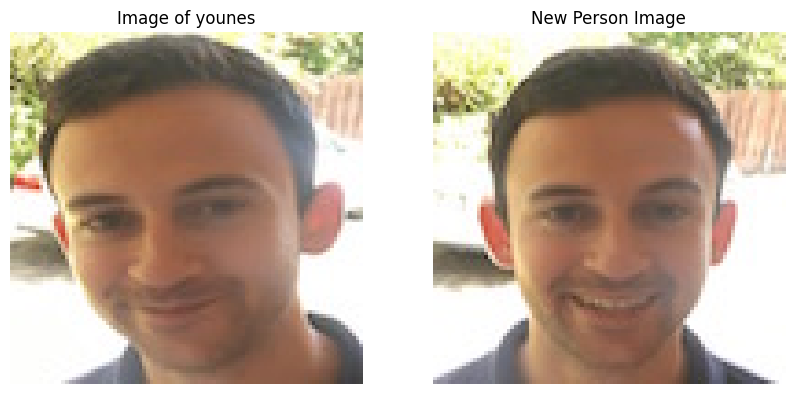

It's younes, the distance is 0.5448771119117737


(np.float32(0.5448771), 'younes')

In [43]:
who_is_it("images/camera_0.jpg", database, FRmodel)

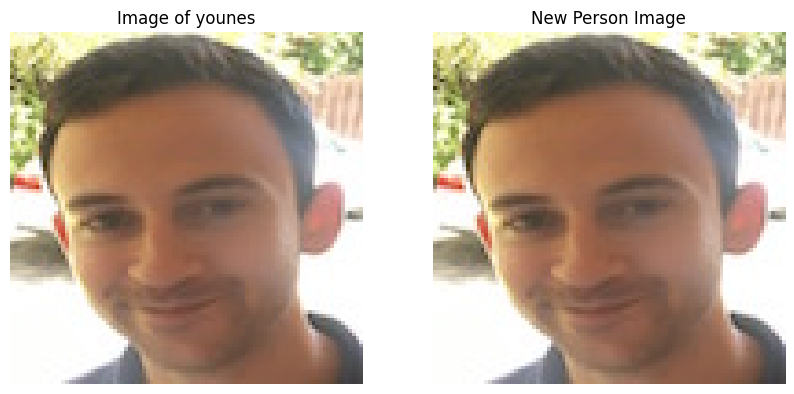

It's younes, the distance is 0.0


(np.float32(0.0), 'younes')

In [44]:
who_is_it("images/younes.jpg", database, FRmodel)

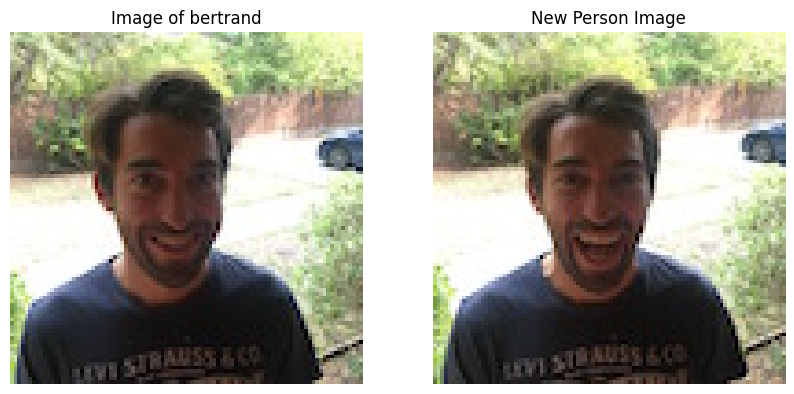

It's bertrand, the distance is 0.6691897511482239


(np.float32(0.66918975), 'bertrand')

In [45]:
who_is_it("images/camera_3.jpg", database, FRmodel)

Not in the database.


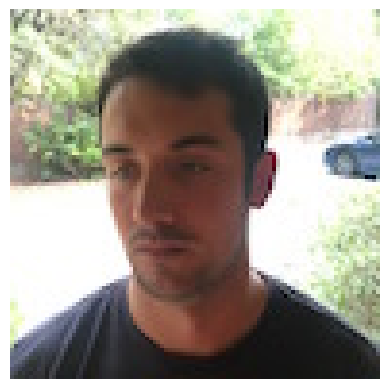

(np.float32(0.8210905), 'arnaud')

In [46]:
who_is_it("images/camera_5.jpg", database, FRmodel)

<a name='6-congratulations'></a>

## 6 - Congratulations 
We have successfully implemented a functional face recognition system that allows authorized individuals to gain access without the need for an ID card. This advancement illustrates our understanding of how a state-of-the-art face recognition system operates, and the distinction between face recognition and face verification.

<a name='6-1-key-accomplishments'></a>

### 6.1 Key Accomplishments:

- **Binary Classification Problem**: We framed face recognition as a binary classification challenge.
- **One-Shot Learning**: We employed one-shot learning techniques to address the face recognition problem.
- **Triplet Loss Function**: We applied the triplet loss function to effectively train the network's parameters in the context of face recognition.
- **Encoding Generation**: We utilized a pretrained model to map face images into 128-dimensional encodings.
- **Verification and Recognition**: We successfully performed both face verification and recognition using these encodings.

<a name='6-2-important-takeaways'></a>
### 6.2 Important Takeaways:

- **Face Verification vs. Face Recognition**: Face verification deals with a simpler 1:1 matching problem, whereas face recognition addresses a more complex 1:K matching problem.
- **Triplet Loss Function**: This is a powerful loss function for training neural networks to learn face image encodings.
- **Distance Measurement**: The same encoding can be utilized for both verification and recognition. By measuring the distances between encodings of two images, we can ascertain whether they represent the same individual.

<a name='6-3-future-enhancements'></a>
### Future Enhancements for the Facial Recognition Model:

While we will not implement these suggestions here, there are several strategies to further enhance the accuracy and robustness of the algorithm:

- **Image Diversity**: Incorporating a larger variety of images for each individual, captured under different lighting conditions and on different days, could improve accuracy. This approach allows comparisons between new images and multiple pictures of each person.
  
- **Image Preprocessing**: Cropping images to focus solely on the face, minimizing the inclusion of extraneous "border" regions, would eliminate irrelevant pixels and enhance the algorithm's robustness.

<a name='7-references'></a>
## 7 - References

1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf).

2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

3. This implementation drew significant inspiration from the official FaceNet GitHub repository: [FaceNet GitHub](https://github.com/davidsandberg/facenet).

4. Additional insights were garnered from: [Machine Learning Mastery - Face Recognition](https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/).

5. Further information can be found at: [Keras FaceNet Implementation](https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/tf_to_keras.ipynb).
